# Notebook to Preprocess MIMIC-III v1.4 Data Files

In this notebook we will preprocess the CSV files in `data/mimic-iii/final` directory, extracted by the MIMIC-CODE library from the MIMIC-III v1.4 database. In particular, this notebook will perform **minimal preprocessing** of the database to extract a dataset of timestamped and typed measurements (incl. *vitals*, *lab results* and *treatment parameters*) and a dataset with demographic information associated with each patient.

The output of this notebook will be a pandas `DataFrame` with three columns:
- `icustay_id`: identifier of ICU admission
- `timestep`: a `DateTime` object specifying the exact time (`charttime`) a measurement was recorded
- `item_id`: an identifier specifying the type of measurement recorded at this timestep, e.g., a vital, such as `HeartRate`; a lab result, such as `Albumin` levels; or a treatment parameter, like `total_iv_fluid`.
- `value`: The value of the actual measurement in the appropriate unit (e.g. ml, bmp, mmHg)

Measurements in the dataset are primarily timestamped, that is *values recorded at specific times*; however, **vasopressor** and **IV fluid intake** are recorded in terms of `(starttime, endtime)` intervals. As these treatments are actions in our **action space**, we sample them every 4 hours much like Roggeveen et al., allowing direct comparison of actions taken at the same points in time.

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from datetime import timedelta
from tqdm import tqdm

DATA_DIR = '../data/mimic-iii/final/'
INTERVAL_TIME = '4H' # To allow comparison with Roggeveen et al.

### Convenience functions

In [2]:
# Read CSV from file and parse dates using pd.to_datetime()
def read_csv(fname):
    df = pd.read_csv(fname)
    
    parse_dates = ['intime', 'outtime', 'starttime', 'endtime', 'window_start', 
                   'window_end', 'charttime', 'suspected_infection_time_poe']
    
    for col in parse_dates:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    return df

---
## Sampling 1-Hour Intervals in 72h Window

In [3]:
cohort_df = read_csv(DATA_DIR + 'cohort.csv')
cohort_df.head()

,subject_id,hadm_id,icustay_id,intime,outtime,suspected_infection_time_poe,window_start,window_end,hospital_expire_flag
0,10006,142345,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 15:30:00,2164-10-22 15:30:00,2164-10-25 15:30:00,0
1,10013,165520,264446,2125-10-04 23:38:00,2125-10-07 15:13:52,2125-10-05 02:00:00,2125-10-04 02:00:00,2125-10-07 02:00:00,1
2,10017,199207,204881,2149-05-29 18:52:29,2149-05-31 22:19:17,2149-05-27 05:15:00,2149-05-26 05:15:00,2149-05-29 05:15:00,0
3,10019,177759,228977,2163-05-14 20:43:56,2163-05-16 03:47:04,2163-05-14 21:52:00,2163-05-13 21:52:00,2163-05-16 21:52:00,1
4,10026,103770,277021,2195-05-17 07:40:18,2195-05-19 17:24:25,2195-05-17 09:12:00,2195-05-16 09:12:00,2195-05-19 09:12:00,0


In [4]:
def get_time_intervals(starttime, endtime):
    timesteps = pd.date_range(start=starttime, end=endtime, freq=INTERVAL_TIME) # ~1 hour
    return list(zip(timesteps[:-1], timesteps[1:]))

# For each interval `(window_start, window_end)` generate list of (start, end) sub-intervals of each 1 hour
interval_times = {x['icustay_id']:get_time_intervals(x['window_start'], x['window_end']) for _, x in cohort_df.iterrows()}

print('Intervals for ICUSTAY 206504:')
for interval_start, interval_stop in interval_times[206504][:10]: # first few for brevity
    print('%s - %s' % (interval_start, str(interval_stop).split()[-1]))

Intervals for ICUSTAY 206504:
2164-10-22 15:30:00 - 19:30:00
2164-10-22 19:30:00 - 23:30:00
2164-10-22 23:30:00 - 03:30:00
2164-10-23 03:30:00 - 07:30:00
2164-10-23 07:30:00 - 11:30:00
2164-10-23 11:30:00 - 15:30:00
2164-10-23 15:30:00 - 19:30:00
2164-10-23 19:30:00 - 23:30:00
2164-10-23 23:30:00 - 03:30:00
2164-10-24 03:30:00 - 07:30:00


---
## Vasopressors

### 1. Resample MetaVision in 1H intervals (MV)

In [5]:
vaso_mv_df = read_csv(DATA_DIR + 'vassopressors_mv_cohort.csv')
vaso_mv_df.head()

,icustay_id,starttime,endtime,rate,rateuom,patientweight,vasoactive_drug,mcgkgmin,mcgmin
0,210989,2144-07-13 11:15:00,2144-07-13 11:30:00,8.013029,mcg/kg/min,81.7,dopamine,0.080130,6.546645
1,210989,2144-07-13 11:30:00,2144-07-13 11:50:00,0.502150,mcg/kg/min,81.7,norepinephrine,0.502150,41.025643
2,210989,2144-07-13 11:30:00,2144-07-13 11:50:00,10.012087,mcg/kg/min,81.7,dopamine,0.100121,8.179875
3,210989,2144-07-13 11:50:00,2144-07-13 11:55:00,0.251075,mcg/kg/min,81.7,norepinephrine,0.251075,20.512822
4,210989,2144-07-13 11:55:00,2144-07-13 19:06:00,0.200979,mcg/kg/min,81.7,norepinephrine,0.200979,16.419956


In [6]:
# Store sampled dfs in list
sampled_vaso_mv_dfs = []

for icustay_id, icustay_data in tqdm(vaso_mv_df.groupby('icustay_id')):
    
    # Part of sepsis-3 cohort?
    if icustay_id not in interval_times:
        continue
        
    # Empty vector to store max_vaso values into
    intervals = interval_times[icustay_id]
    max_vaso = np.zeros(len(intervals), dtype=np.float64)
    
    for i, (interval_start, interval_end) in enumerate(intervals):        
        # Inclusion test: treatment timeframe overlaps with current window.
        # NOTE: original R-code erroneously used `endtime < interval_end`
        condition = (icustay_data['starttime'] <= interval_end) & (icustay_data['endtime'] > interval_start)
        
        # Compute max vasopressor dose administered
        max_vaso[i] = icustay_data[condition]['mcgkgmin'].max() # Why max?
        
    # Create DataFrame
    sampled_vaso_mv_df = pd.DataFrame(index=range(len(intervals)))
    sampled_vaso_mv_df['icustay_id'] = icustay_id
    sampled_vaso_mv_df['timestep'] = [end for _, end in intervals]
    sampled_vaso_mv_df['item_id'] = 'max_vaso'
    sampled_vaso_mv_df['value'] = np.nan_to_num(max_vaso, nan=0.0) # NaN = 0
    sampled_vaso_mv_dfs.append(sampled_vaso_mv_df)
    
# Concat DataFrames of individual icustays
sampled_vaso_mv_df = pd.concat(sampled_vaso_mv_dfs)
sampled_vaso_mv_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 57.12it/s]


,icustay_id,timestep,item_id,value
0,210989,2144-07-10 21:57:00,max_vaso,0.0
1,210989,2144-07-11 01:57:00,max_vaso,0.0
2,210989,2144-07-11 05:57:00,max_vaso,0.0
3,210989,2144-07-11 09:57:00,max_vaso,0.0
4,210989,2144-07-11 13:57:00,max_vaso,0.0


#### Visual check

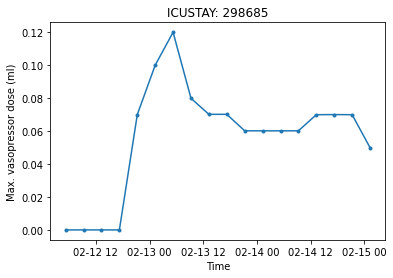

In [7]:
# Get max vaso for one random patient
icustay_id = random.choice(sampled_vaso_mv_df['icustay_id'].values)
single_icustay_max_vaso = sampled_vaso_mv_df[sampled_vaso_mv_df['icustay_id'] == icustay_id]

plt.title('ICUSTAY: %s' % icustay_id)
plt.ylabel('Max. vasopressor dose (ml)')
plt.xlabel('Time')
plt.plot(single_icustay_max_vaso['timestep'], single_icustay_max_vaso['value'], '.-');

---
## IV Fluids

### 1. Resample MetaVision in 1H intervals (MV)

In [8]:
ivfluid_mv_df = read_csv(DATA_DIR + 'inputevents_mv_cohort.csv')

# Drop 14-Oral/Gastric Intake (i.e. having a glass of water)
condition = (ivfluid_mv_df['ordercategoryname'] != '14-Oral/Gastric Intake') & (ivfluid_mv_df['amountuom'] == 'ml')
ivfluid_mv_df = ivfluid_mv_df.loc[condition]

# Sanity check: remove amounts outside (0, 5000) range
condition = (ivfluid_mv_df['amount'] > 0) & (ivfluid_mv_df['amount'] < 5000)
ivfluid_mv_df = ivfluid_mv_df.loc[condition]

# Compute duration in hours
# NOTE: original erroneously measured time in minutes
ivfluid_mv_df['duration'] = (ivfluid_mv_df['endtime'] - ivfluid_mv_df['starttime']).astype('timedelta64[s]').astype(int) / 3600

# Drop many useless columns
ivfluid_mv_df = ivfluid_mv_df[['subject_id', 'hadm_id', 'icustay_id', 'starttime', 'endtime', 'amount', 'duration']]
ivfluid_mv_df.head()

,subject_id,hadm_id,icustay_id,starttime,endtime,amount,duration
1,40124,126179,279554,2130-02-04 20:21:00,2130-02-05 04:07:00,999.999978,7.766667
2,40124,126179,279554,2130-02-04 12:36:00,2130-02-04 18:39:00,907.500000,6.050000
4,40124,126179,279554,2130-02-04 14:46:00,2130-02-05 09:01:00,164.299998,18.250000
5,40124,126179,279554,2130-02-05 11:06:00,2130-02-05 15:06:00,499.999992,4.000000
7,40124,126179,279554,2130-02-04 20:21:00,2130-02-05 04:21:00,999.999984,8.000000


In [9]:
# Computes how much of each treatment was administered between window_start and window_end
def total_administration_in_window(window_start, window_end, fluid_df):
    dose_start = fluid_df['starttime']
    dose_end = fluid_df['endtime']
    amount = fluid_df['amount']
    duration = fluid_df['duration']
    rate = amount / duration    
    total = 0
    
    # Option 1: Dose started before window and ended after window
    c1 = (dose_start < window_start) & (dose_end > window_end)
    if c1.any():
        window_duration = (window_end - window_start).total_seconds() / 3600
        total += (window_duration * rate[c1]).sum()
    
    # Option 2: Dose started before and ended within window
    c2 = (dose_start < window_start) & (dose_end > window_start) & (dose_end <= window_end)
    if c2.any():
        rear_overlap = (dose_end - window_start).astype('timedelta64[s]').astype(int) / 3600
        total += (rear_overlap * rate[c2]).sum()
    
    # Option 3: Dose started and ended in window
    c3 = (dose_start >= window_start) & (dose_start < window_end) & (dose_end <= window_end) & (dose_end > window_start)
    if c3.any():
        total += amount[c3].sum()
    
    # Option 4: Window started before and ended within dose
    c4 = (window_start < dose_start) & (window_end > dose_start) & (window_end < dose_end)
    if c4.any():
        front_overlap = (window_end - dose_start).astype('timedelta64[s]').astype(int) / 3600
        total += (front_overlap * rate[c4]).sum()
            
    return total

In [10]:
# Store sampled dfs in list
sampled_ivfluid_mv_dfs = []

# Consider ICU stays one-by-one
print('Grab some coffee!')
for icustay_id, icustay_data in tqdm(ivfluid_mv_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in interval_times:
        continue
        
    # Accumulate IV fluids in numpy Ndarray
    intervals = interval_times[icustay_id]
    total_ivfluid = np.zeros(len(intervals), dtype=np.float64)
    
    for i, (interval_start, interval_end) in enumerate(intervals):
        total_ivfluid[i] = total_administration_in_window(interval_start, interval_end, icustay_data)
                
    # Create DataFrame
    sampled_ivfluid_df = pd.DataFrame(index=range(len(intervals)))
    sampled_ivfluid_df['icustay_id'] = icustay_id
    sampled_ivfluid_df['timestep'] = [end for _, end in intervals]
    sampled_ivfluid_df['item_id'] = 'total_ivfluid'
    sampled_ivfluid_df['value'] = np.nan_to_num(total_ivfluid, nan=0.0) # NaN = 0
    sampled_ivfluid_mv_dfs.append(sampled_ivfluid_df)
    
# Concat DataFrames of individual icustays
sampled_ivfluid_mv_df = pd.concat(sampled_ivfluid_mv_dfs)
sampled_ivfluid_mv_df.head()

Grab some coffee!


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 30.48it/s]


,icustay_id,timestep,item_id,value
0,201204,2121-12-07 03:00:00,total_ivfluid,0.0
1,201204,2121-12-07 07:00:00,total_ivfluid,0.0
2,201204,2121-12-07 11:00:00,total_ivfluid,0.0
3,201204,2121-12-07 15:00:00,total_ivfluid,0.0
4,201204,2121-12-07 19:00:00,total_ivfluid,0.0


#### Visual check

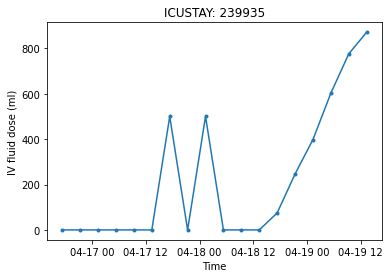

In [11]:
# Get total IV fluid intake for one random patient
icustay_id = 239935#random.choice(sampled_ivfluid_mv_df['icustay_id'].values)
single_icustay_ivfluid = sampled_ivfluid_mv_df[sampled_ivfluid_mv_df['icustay_id'] == icustay_id]

plt.title('ICUSTAY: %s' % icustay_id)
plt.ylabel('IV fluid dose (ml)')
plt.xlabel('Time')
plt.plot(single_icustay_ivfluid['timestep'], single_icustay_ivfluid['value'], '.-');

---
## Vitals

In [12]:
vitals_df = read_csv(DATA_DIR + 'vitals_cohort.csv')
vitals_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,vital_id,valuenum
0,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,DiasBP,50.000000
1,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,HeartRate,104.000000
2,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,MeanBP,63.666698
3,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,RespRate,25.000000
4,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 22:40:00,SpO2,98.000000


In [13]:
# Simply rename columns (vitals_df is already in the right format)
new_vitals_df = pd.DataFrame({'icustay_id': vitals_df['icustay_id'],
                              'timestep': vitals_df['charttime'],
                              'item_id': vitals_df['vital_id'],
                              'value': vitals_df['valuenum']})
new_vitals_df.head()

,icustay_id,timestep,item_id,value
0,206504,2164-10-23 22:40:00,DiasBP,50.000000
1,206504,2164-10-23 22:40:00,HeartRate,104.000000
2,206504,2164-10-23 22:40:00,MeanBP,63.666698
3,206504,2164-10-23 22:40:00,RespRate,25.000000
4,206504,2164-10-23 22:40:00,SpO2,98.000000


---
## Lab Results

In [14]:
lab_df = read_csv(DATA_DIR + 'labs_cohort.csv')
lab_df.head()

,subject_id,hadm_id,icustay_id,window_start,window_end,intime,outtime,charttime,lab_id,valuenum
0,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:33:00,LACTATE,4.4
1,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ALAT,9.0
2,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ALBUMIN,3.4
3,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ANION GAP,20.0
4,10006,142345,206504,2164-10-22 15:30:00,2164-10-25 15:30:00,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 17:38:00,ASAT,40.0


In [15]:
# Simply rename columns (lab_df is already in the right format)
new_lab_df = pd.DataFrame({'icustay_id': lab_df['icustay_id'],
                           'timestep': lab_df['charttime'],
                           'item_id': lab_df['lab_id'],
                           'value': lab_df['valuenum']})
new_lab_df.head()

,icustay_id,timestep,item_id,value
0,206504,2164-10-23 17:33:00,LACTATE,4.4
1,206504,2164-10-23 17:38:00,ALAT,9.0
2,206504,2164-10-23 17:38:00,ALBUMIN,3.4
3,206504,2164-10-23 17:38:00,ANION GAP,20.0
4,206504,2164-10-23 17:38:00,ASAT,40.0


---
## FiO2 (Fraction of Inspired Oxygen)

In [16]:
fio2_df = read_csv(DATA_DIR + 'fio2_cohort.csv')
fio2_df.head()

,subject_id,hadm_id,icustay_id,charttime,fio2
0,10013,165520,264446,2125-10-05 00:00:00,60.000002
1,10013,165520,264446,2125-10-05 01:00:00,40.000001
2,10013,165520,264446,2125-10-05 03:00:00,40.000001
3,10013,165520,264446,2125-10-05 07:00:00,69.999999
4,10013,165520,264446,2125-10-05 10:00:00,69.999999


In [17]:
new_fio2_df = pd.DataFrame({'icustay_id': fio2_df['icustay_id'],
                            'timestep': fio2_df['charttime'],
                            'item_id': 'FiO2',
                            'value': fio2_df['fio2']})
new_fio2_df.head()

,icustay_id,timestep,item_id,value
0,264446,2125-10-05 00:00:00,FiO2,60.000002
1,264446,2125-10-05 01:00:00,FiO2,40.000001
2,264446,2125-10-05 03:00:00,FiO2,40.000001
3,264446,2125-10-05 07:00:00,FiO2,69.999999
4,264446,2125-10-05 10:00:00,FiO2,69.999999


---
## Urine Output

In [18]:
urineoutput_df = read_csv(DATA_DIR + 'urineoutput_cohort.csv')
urineoutput_df.head()

,subject_id,hadm_id,icustay_id,charttime,value
0,10045,126949,203766,2129-11-26 08:00:00,6
1,40310,186361,210989,2144-07-13 06:00:00,10
2,42075,151323,298685,2166-02-13 01:00:00,15
3,10032,140372,267090,2138-04-09 10:00:00,40
4,10044,124073,270154,2152-10-03 11:00:00,200


In [19]:
new_urineoutput_df = pd.DataFrame({'icustay_id': urineoutput_df['icustay_id'],
                                   'timestep': urineoutput_df['charttime'],
                                   'item_id': 'UrineOutput',
                                   'value': urineoutput_df['value']})
new_urineoutput_df.head()

,icustay_id,timestep,item_id,value
0,203766,2129-11-26 08:00:00,UrineOutput,6
1,210989,2144-07-13 06:00:00,UrineOutput,10
2,298685,2166-02-13 01:00:00,UrineOutput,15
3,267090,2138-04-09 10:00:00,UrineOutput,40
4,270154,2152-10-03 11:00:00,UrineOutput,200


---
## Putting it all together

In [20]:
# Merge measurement DataFrames
full_df = pd.concat([sampled_vaso_mv_df, 
                     sampled_ivfluid_mv_df, 
                     new_vitals_df, 
                     new_lab_df, 
                     new_fio2_df, 
                     new_urineoutput_df]).dropna(axis=0).reset_index(drop=True)

# Group ICU-stays and by increasing timestep
full_df = full_df.sort_values(by=['icustay_id', 'timestep'])
full_df.head(30)

,icustay_id,timestep,item_id,value
18739,201006,2107-03-22 06:10:00,ALAT,37.0
18740,201006,2107-03-22 06:10:00,ANION GAP,14.0
18741,201006,2107-03-22 06:10:00,ASAT,40.0
18742,201006,2107-03-22 06:10:00,BANDS,1.0
18743,201006,2107-03-22 06:10:00,BICARBONATE,23.0
18744,201006,2107-03-22 06:10:00,BILIRUBIN,0.9
18745,201006,2107-03-22 06:10:00,BUN,16.0
18746,201006,2107-03-22 06:10:00,CALCIUM,7.7
18747,201006,2107-03-22 06:10:00,CHLORIDE,103.0
18748,201006,2107-03-22 06:10:00,CREATININE,0.8


#### Estimated memory usage

In [23]:
# Size of current dataset with current ICU stays
full_df_gigs = full_df.memory_usage(deep=True).sum() / (1 << 30)
num_icustay_ids = len(set(full_df['icustay_id']))
print('Number of ICU-stay ids:', num_icustay_ids)

# Expected GB of whole 40.000 ICU stays in MIMIC-III
exp_gigs = 40000 * full_df_gigs / num_icustay_ids

print('Expected memory usage of dataset: %sGB' % round(exp_gigs, 2)) 

Number of ICU-stay ids: 59
Expected memory usage of dataset: 1.48GB


#### Visual Check

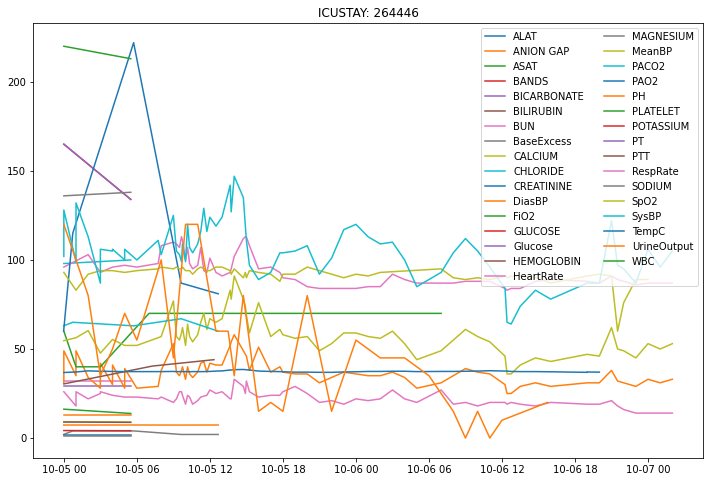

In [22]:
icustay_id = random.choice(full_df['icustay_id'].values)
icustay_df = full_df[full_df['icustay_id'] == icustay_id]

plt.figure(figsize=(12, 8))

for item_id, item_df in icustay_df.groupby('item_id'):
    timesteps = item_df['timestep']
    values = item_df['value']
    
    plt.plot(timesteps, values, label=item_id)
    
plt.title('ICUSTAY: %s' % icustay_id)
plt.legend(ncol=2)
plt.show()